# Background

- [DB](http://www.chimpanzeebrain.org/mri-datasets-for-direct-download)
- [Simple ITK Image Basics](http://simpleitk.github.io/SimpleITK-Notebooks/01_Image_Basics.html)

I will try to following these VTK and ITK tutorials:
- [Image Segmentation with Python and SimpleITK](https://pyscience.wordpress.com/2014/10/19/image-segmentation-with-python-and-simpleitk/)
    - [Jupyter notebook](http://nbviewer.jupyter.org/urls/bitbucket.org/somada141/pyscience/raw/master/20141001_SegmentationSimpleITK/Material/SegmentationSimpleITK.ipynb)

# Imports

In [1]:
import os
import numpy
import SimpleITK
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Functions

In [2]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

# Parameters

In [3]:
inpath = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Monkey//10 sample Chimpanzee 3T for NCBR website//Male_Fritz.nii'
# inpath = "C://Cerebral//_MarioSandBox//DB//medicalHolography//UofT Mouse Brain//C57brain.mnc"

In [4]:
# Z slice of the DICOM files to process. In the interest of
# simplicity, segmentation will be limited to a single 2D
# image but all processes are entirely applicable to the 3D image
idxSlice = 50

# int labels to assign to the segmented white and gray matter.
# These need to be different integers but their values themselves
# don't matter
labelWhiteMatter = 1
labelGrayMatter = 2

# Reading Data

In [5]:
reader = SimpleITK.ImageFileReader()
image = SimpleITK.ReadImage(inpath)

# Display the data

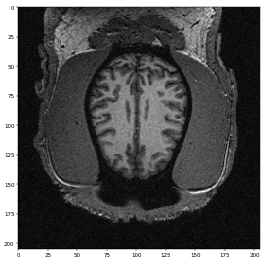

In [6]:
idxSlice = 50
imgOriginal = image[:,:,idxSlice]
sitk_show(imgOriginal)

# Smoothing

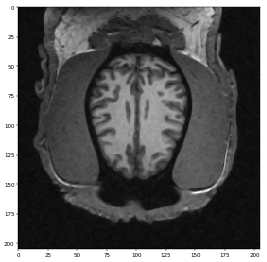

In [7]:
imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
                                    timeStep=0.125,
                                    numberOfIterations=5)

# blurFilter = SimpleITK.CurvatureFlowImageFilter()
# blurFilter.SetNumberOfIterations(5)
# blurFilter.SetTimeStep(0.125)
# imgSmooth = blurFilter.Execute(imgOriginal)

sitk_show(imgSmooth)

We are basically just smoothing the images so that it doesn't have that grainy look to it.

# Segmentation with the CoonectedThreshold filter

## Gray Matter Segmentation

Note that I am merely guessing the lower and upper bounds of the thresholding. 

In this case I am guessing them to be between 90-200 starting with the seed at pt.[90,90]

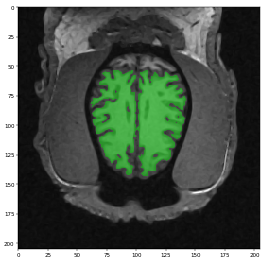

In [41]:
lstSeeds = [(90,90)]

imgWhiteMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                              seedList=lstSeeds, 
                                              lower=90, 
                                              upper=200,
                                              replaceValue=labelWhiteMatter)

# Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

# Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

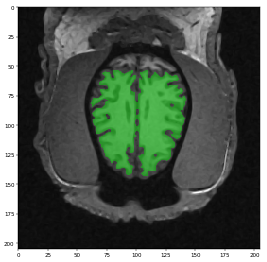

In [42]:
imgWhiteMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgWhiteMatter,
                                                          radius=[2]*3,
                                                          majorityThreshold=1,
                                                          backgroundValue=0,
                                                          foregroundValue=labelWhiteMatter)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles))

## White Matter Segmentation

Note that I am merely guessing the lower and upper bounds of the thresholding. 

In this case I am guessing them to be between 40-90 starting with the seed at pt.[80,90]

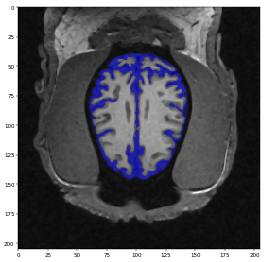

In [45]:
lstSeeds = [(80,90)]

imgGrayMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                             seedList=lstSeeds, 
                                             lower=40, 
                                             upper=90,
                                             replaceValue=labelGrayMatter)

imgGrayMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgGrayMatter,
                                                         radius=[2]*3,
                                                         majorityThreshold=1,
                                                         backgroundValue=0,
                                                         foregroundValue=labelGrayMatter)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgGrayMatterNoHoles))

## Overlay

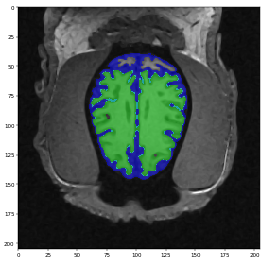

In [47]:
imgLabels = imgWhiteMatterNoHoles | imgGrayMatterNoHoles


sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels))